# Поведение пользователей мобильного приложения по продаже продуктов питания

Наш стартап продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения. 

Для этого В ходе исследовательского анализа данных будут совершены следующие действия:

1. Изучение воронку продаж. Анализ, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах.
2. Исследование результаты A/A/B-эксперимента. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. 

### Открытие файла с данными и изучение общей информации. 

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy import stats as st
import numpy as np
import math as mth

In [2]:
logs = pd.read_csv('/datasets/...')

In [3]:
#выводим 5 первых строк, чтобы взглянуть на саму таблицу
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
#выводим общую информацию по ДФ
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
#выводим размеры ДФ
logs.shape

(244126, 4)

На первый взгляд, таблица состоит из 4 столбцов и 244126 строк, 3 столбца из которых содержат целые числа, а 1 - строчные значения. Также в таблице отсутствуют пропуски.

### Подготовка данных. 

Заменим названия столбцов.

In [6]:
logs = logs.rename(
    columns={
        'EventName': 'event_name',
        'DeviceIDHash': 'device_id',
        'EventTimestamp': 'datetime',
        'ExpId': 'experiment_id'
    }
)

Исходя из полученных выше данных, пропусков в столбцах нет. Однако, столбец с датой следует привести в надлежащий вид.

In [7]:
logs['datetime'] = pd.to_datetime(logs['datetime'], unit='s')

In [8]:
#добавим дополнительный столбец только с датой
logs['date'] = pd.to_datetime(logs['datetime']).dt.date

In [9]:
#проверим ДФ на наличие явных дубликатов
print(logs.duplicated().sum())

#удалим их
logs = logs.drop_duplicates()

413


### Изучение и проверка данных.

**Сколько всего событий в логе?**

In [11]:
print('Всего в логе', len(logs), 'событий.')

Всего в логе 243713 событий.


In [12]:
logs['event_name'].nunique()

5

Уникальных в логе существует 5  событий. Чтобы познакомиться с ними ближе, можно вывести их названия.

In [13]:
logs['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

**Сколько всего пользователей в логе?**

In [14]:
logs['device_id'].nunique()

7551

А вот пользователей уже на порядок больше логов - 7551 юзер был замечен в приложении нашего стартапа. Можно себя считать уже  успешными?)

**Сколько в среднем событий приходится на пользователя?**

In [15]:
log_amount = (logs.groupby('device_id')['event_name'].count()).mean().round().astype(int)
print('В среднем на одного пользователя приходится', log_amount, 'события.')

В среднем на одного пользователя приходится 32 события.


**Данными за какой период вы располагаете?**

In [16]:
#для начала, определим минимальную дату в нашем датафрейме
print('Минимальная дата:', logs['datetime'].min())

#и максимальную
print('Максимальная дата:', logs['datetime'].max())

#определим, какой это промежуток времени 
print('В датафрейме содержится информация за', logs['datetime'].max() - logs['datetime'].min())

Минимальная дата: 2019-07-25 04:43:36
Максимальная дата: 2019-08-07 21:15:17
В датафрейме содержится информация за 13 days 16:31:41


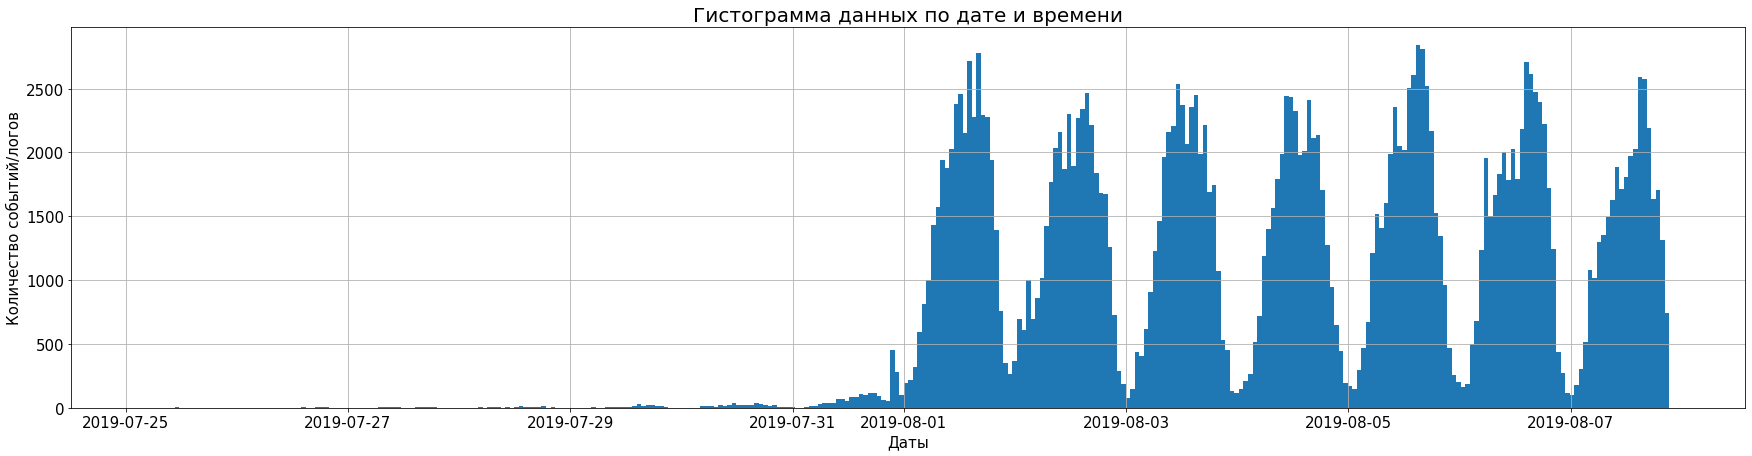

In [17]:
plt.figure(figsize=(30, 7))
logs['datetime'].hist(bins=14*24)
plt.title('Гистограмма данных по дате и времени', fontsize=20)
plt.xlabel("Даты", fontsize=15)
plt.ylabel("Количество событий/логов", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

Таким образом, на первый взгляд, в наших данных содержится информация почти за 2 недели пользовательской активности - начиная с 25 июля 2019 года до 7 августа 2019 года. 

Однако, обращая внимание на гистограмму стоит заметить, что вплоть до 01.08.2019 данных в сумме меньше 5000, в то время как остальные дни, начиная с 01.08.2019, это значение колеблется в районе 35000.

Это можно объяснить тем, что технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Необходимо определить, с какого момента данные полные и отбросить более старые. 

In [18]:
logs2 = logs[logs['date'] >= dt.date(2019, 8, 1)] 

In [19]:
#повторно определим, какой это промежуток времени 
print('В датафрейме содержится информация за', logs['datetime'].max() - logs['datetime'].min())

В датафрейме содержится информация за 13 days 16:31:41


Итак, в итоговом датафрейме мы располагаем данными за неделю - почти 7 полных дней. После того, как мы отбросили старые данные, логи в анализируемых 7 днях распределены нормально и равномерно между собой.

**Много ли событий и пользователей вы потеряли, отбросив старые данные?**

In [20]:
log_dif = len(logs['event_name']) - len(logs2['event_name'])
per_log_dif = round((log_dif / len(logs['event_name']) * 100), 2)
print('Количество событий уменьшилось на', log_dif, ', что составляет', per_log_dif, '% от первоначального датафрейма.')

user_dif = logs['device_id'].nunique() - logs2['device_id'].nunique()
per_user_dif = round(user_dif / logs['device_id'].nunique() * 100, 2)
print('Количество пользователей уменьшилось на', user_dif, ', что составляет', per_user_dif, '% от первоначального датафрейма.')

Количество событий уменьшилось на 2826 , что составляет 1.16 % от первоначального датафрейма.
Количество пользователей уменьшилось на 17 , что составляет 0.23 % от первоначального датафрейма.


Таким образом, отбросив старые данные мы потеряли 2826 событий и 17 пользователей, что составляет 1.16 и 0.23% от первоначального датафрейма. Соответственно, можно с уверенностью утверждать, что много данных мы не потеряли и это не скажется на дальнейшем иследовании.

In [21]:
#очень хочется переписать итоговый датафрейм просто в logs, чтобы не путаться и не копить бесконечные нейминги
logs = logs2

**Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.**

За экспериментальные группы у нас отвечает столбец experiment_id. 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [22]:
#сначала составим датафрейм с уникальными пользователями
users = logs[['device_id', 'experiment_id']].drop_duplicates()

#дальше можно считать, сколько юзеров в какой группе и их соотношение
experiment_id_246 = len(users[users['experiment_id'] == 246])
experiment_id_247 = len(users[users['experiment_id'] == 247])
experiment_id_248 = len(users[users['experiment_id'] == 248])
print('Количество пользователей в 246 группе -', experiment_id_246,
     ', в 247 группе -', experiment_id_247,
     ', в 248 группе -', experiment_id_248)

Количество пользователей в 246 группе - 2484 , в 247 группе - 2513 , в 248 группе - 2537


Согласно полученным данным, в контрольных 246 и 247 группах со 2484 и 2513 пользователей. В экспериментальной 248 пользователей 2537. То есть распределение пользователей по группам нормально и достаточно равномерно для дальнейшего исследования.

### Изучение воронки событий

**Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.**

Ранее мы уже выяснили, что всего в логе 5 видов событий:
- 'MainScreenAppear', 
- 'PaymentScreenSuccessful', 
- 'CartScreenAppear',
- 'OffersScreenAppear', 
- 'Tutorial'

In [23]:
#выясним, как часто они встречаются
logs['event_name'].value_counts().sort_values(ascending=False)

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

В частоте событий прослеживается явная логика - чаще всего случается такое событие, как показ основного окна (117328 раз в наших данных за неделю), далее идет окно в предложениями (46333), окно корзины (42303) и окно с успешной оплатой (33918). Завершает все общий туториал, который встречается гораздо реже всех остальных окон (1005).

**Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.**

Логика этой задачи отличается от предыдущей только тем, что одному пользователю различные окна могли быть показаны более, чем 1 раз. Поэтому мы совершим все те же вычисления, перед этим сократив датафрейм до уникальных комбинаций событие-юзер.

In [24]:
unique_users = (logs[['event_name', 'device_id']].drop_duplicates()
                                                 .groupby('event_name')
                                                 .agg({'device_id': 'count'})
                                                 .sort_values(by='device_id', ascending=False)
                                                 .rename(columns={"device_id": "users"})
)
#добавим столбец с долей пользователей
unique_users['percent'] = round(unique_users['users'] / logs['device_id'].nunique()*100, 2)
unique_users

,users,percent
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


- Основное окно было показано 98.47 % пользователей.
- Окно с предложениями было показано 60.96 % пользователей.
- Окно с корзиной было показано 49.56 % пользователей.
- Окно успешной оплаты было показано 46.97 % пользователей.
- Окно с руководством было показано 11.15 % пользователей.

**Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?**

На этот вопрос мы уже давали ответ выше, но можно его повторить. Скорее всего, события происходят в том же порядке, в котором они представлены в таблице по частоте их показа пользователям. Почти всем сначала демонстрируется основной экран мобильного приложения (98.5%), смею предположить, что 1.5% сессий, попавших в исследование, где основной экран не был показан - это логи в приложении с ошибками, когда пользователя сразу выкидывало и приходилось заходить повторно. Далее - демонстрация экрана с предложениями - тут уже почти 61%, до корзины доходит почти 50% пользователей, экран с успешной оплатой заказа - у 47%. Кажется логичным, что экран с руководством не является обязательным в цепочке пользователя от момента посещения приложения и оплаты заказа, поэтому он зафиксирован только у 11% пользователей - возможно, это те, кто столкнулись с какими-либо трудностями при использовании нашего приложения.

**По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).**

In [25]:
unique_users['conversion'] = round(unique_users['users'] / unique_users['users'].shift(periods=1), 2)
unique_users

,users,percent,conversion
event_name,,,
MainScreenAppear,7419,98.47,NaN
OffersScreenAppear,4593,60.96,0.62
CartScreenAppear,3734,49.56,0.81
PaymentScreenSuccessful,3539,46.97,0.95
Tutorial,840,11.15,0.24


Согласно полученным данным, конверсия пользователя из основной страницы на страницу продукта - 0.62, со страницы продукта в корзину - 0.81, из корзины на экран успешной оплаты заказа - 0.95, и со страницы успешной оплаты на руководство - 0.24. 

**На каком шаге теряете больше всего пользователей?**

Хоть по числовым показателям последняя конверсия из PaymentScreenSuccessful в Tutorial показывает наименьший результат, она нас мало интересует, так как пользователь уже успешно конвертировался в покупателя и последняя метрика не влияет на бизнес в целом. Поэтому можно сказать, что больше всего пользователей теряется на моменте перехода с открытия главной страницы на страницу продукта (конверсия в 0.62 -> из 7419 пользователей "дошло" только 4593). Возможно, такую низкую конверсию можно объяснить, помимо того, что клиент не нашел искомый продукт, также тем, что пользователь мог зайти в приложение по ошибке или вылететь из-за какого-то лага.

**Какая доля пользователей доходит от первого события до оплаты?**

Первым событием, логично, является открытие основной страницы - оно у нас в составленном датафрейме является самым часто встречающимся, оплата - предпоследняя. Вычислим, сколько из пользователей, открывших приложение, дошли до оплаты.

In [26]:
print(round(unique_users['users'].loc[unique_users.index[-2]] / unique_users['users'].loc[unique_users.index[0]], 2))

0.48


Почти половина пользователей, которые открывают наше приложение, совершают в итоге покупку - неплохой показатель, но, думаю, следует проанализировать, почему такое количество пользователей "отваливается" на этапе выбора товара, чтобы определить потенциальные точки роста. Однако, об этом в другой раз))

### Изучите результаты эксперимента

**Сколько пользователей в каждой экспериментальной группе?**

Ранее мы писали код, благодаря которому определили количество пользователей в каждой группе. Продублируем его здесь.

In [27]:
print('Количество пользователей в 246 группе -', experiment_id_246,
     ', в 247 группе -', experiment_id_247,
     ', в 248 группе -', experiment_id_248)

Количество пользователей в 246 группе - 2484 , в 247 группе - 2513 , в 248 группе - 2537


**Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.**

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов: 246 и 247.

Критерии успешного A/A-теста: 
- Количество пользователей в различных группах различается не более, чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

In [28]:
print(round(abs(experiment_id_246 / experiment_id_247 * 100 - 100), 1))

1.2


Количество пользователей в различных группах различается на 1,2% - это больше, чем допустимый 1% для успешного А/А-теста, будем иметь это в виду.

In [29]:
#построим сводную таблицу по шагам для каждой из групп и заодно посчитаем конверсию
users_246 = (logs[['event_name', 'device_id']][logs['experiment_id'] == 246].drop_duplicates()
                                              .groupby('event_name')
                                              .agg({'device_id': 'count'})
                                              .sort_values(by='device_id', ascending=False)
                                              .rename(columns={"device_id": "users_246"})
)
users_246['conversion_246'] = round(users_246['users_246'] / users_246['users_246'].shift(periods=1), 2)

users_247 = (logs[['event_name', 'device_id']][logs['experiment_id'] == 247].drop_duplicates()
                                              .groupby('event_name')
                                              .agg({'device_id': 'count'})
                                              .sort_values(by='device_id', ascending=False)
                                              .rename(columns={"device_id": "users_247"})
)
users_247['conversion_247'] = round(users_247['users_247'] / users_247['users_247'].shift(periods=1), 2)

#объединим 2 таблицы
aa_test_users = users_246.merge(users_247, on='event_name')

aa_test_users

,users_246,conversion_246,users_247,conversion_247
event_name,,,,
MainScreenAppear,2450,NaN,2476,NaN
OffersScreenAppear,1542,0.63,1520,0.61
CartScreenAppear,1266,0.82,1238,0.81
PaymentScreenSuccessful,1200,0.95,1158,0.94
Tutorial,278,0.23,283,0.24


В нашем исследовании мы применяем точность A/A-теста в 1% — самый распространённый критерий. Так как ключевой метрикой по группам является именно конверсия пользователя и переход из одной страницы на другую - посчитали разницу двух конверсий в контольных группах. Только в одном случае она составила 0.02 вместо 0.01 - при анализе пользователей, перешедших из основного экрана в карточку товара. Также следует это отметить.

In [30]:
#создадим 2 Series с id пользователей для каждой группы
id_246 = logs['device_id'][logs['experiment_id'] == 246].drop_duplicates()
id_247 = logs['device_id'][logs['experiment_id'] == 247].drop_duplicates()

#выведем количество значений, которые повторяются в обоих группах
len(id_246[id_246.isin(id_247)])

0

Мы можем утверждать, что у нас попавший в одну из групп посетитель оставлся в этой группе до конца теста.

Таким образом, можно сделать вывод, что критерии успешного А/А-теста по большей части соблюдены и механизмы и рассчеты должны быть корректны.

**Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий. Можно ли сказать, что разбиение на группы работает корректно?**

Поставленную задачу мы опять случайно сделали слегка заранее)) Еще раз взглянем на полученную таблицу. 

In [31]:
aa_test_users

,users_246,conversion_246,users_247,conversion_247
event_name,,,,
MainScreenAppear,2450,NaN,2476,NaN
OffersScreenAppear,1542,0.63,1520,0.61
CartScreenAppear,1266,0.82,1238,0.81
PaymentScreenSuccessful,1200,0.95,1158,0.94
Tutorial,278,0.23,283,0.24


Единственные данные, которых нам недостает - это сколько пользователей из контрольной группы совершили хотя бы первое действие - открыли главный экран. Дополним таблицу необходимыми сведениями и сравним получившиеся результаты еще раз.

In [32]:
aa_test_users['conversion_246'].loc[aa_test_users.index[0]] = round(aa_test_users['users_246'].loc[aa_test_users.index[0]] / logs['device_id'][logs['experiment_id'] == 246].nunique(), 2)
aa_test_users['conversion_247'].loc[aa_test_users.index[0]] = round(aa_test_users['users_247'].loc[aa_test_users.index[0]] / logs['device_id'][logs['experiment_id'] == 247].nunique(), 2)

In [33]:
aa_test_users

,users_246,conversion_246,users_247,conversion_247
event_name,,,,
MainScreenAppear,2450,0.99,2476,0.99
OffersScreenAppear,1542,0.63,1520,0.61
CartScreenAppear,1266,0.82,1238,0.81
PaymentScreenSuccessful,1200,0.95,1158,0.94
Tutorial,278,0.23,283,0.24


Для того, чтобы проверить, будет ли отличие между группами статистически достоверным, нужно проверить гипотезы о равенстве долей.

In [34]:
#функция для проверки гипотезы о равенстве долей
def equalty(successes, trials):
    
    alpha = .05 # критический уровень статистической значимости
    
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
    
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

In [35]:
#сначала проверим гипотезу равенства долей всех пользователей и тех, кто открыл основную страницу
successes = np.array([aa_test_users['users_246'].loc[aa_test_users.index[0]], aa_test_users['users_247'].loc[aa_test_users.index[0]]])
trials = np.array([logs['device_id'][logs['experiment_id'] == 246].nunique(), logs['device_id'][logs['experiment_id'] == 247].nunique()])

equalty(successes, trials)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [36]:
#оставшиеся итерации можем обернуть в цикл, так как будем обращаться к одной и той же таблице

for i in range(aa_test_users.shape[0] - 1):
    successes = np.array([aa_test_users['users_246'].iloc[i+1], aa_test_users['users_247'].iloc[i+1]])
    trials = np.array([aa_test_users['users_246'].iloc[i], aa_test_users['users_247'].iloc[i]])
    
    
    print(f'При сравнении доли пользователей, перешедших на {aa_test_users.index[i+1]} из {aa_test_users.index[i]}:')
    equalty(successes, trials)
    print()

При сравнении доли пользователей, перешедших на OffersScreenAppear из MainScreenAppear:
p-значение:  0.2622344959255778
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

При сравнении доли пользователей, перешедших на CartScreenAppear из OffersScreenAppear:
p-значение:  0.6393754713145263
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

При сравнении доли пользователей, перешедших на PaymentScreenSuccessful из CartScreenAppear:
p-значение:  0.18243439408067652
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

При сравнении доли пользователей, перешедших на Tutorial из PaymentScreenSuccessful:
p-значение:  0.46833167209360305
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Таким образом, разница во всех пропорциях при указанных размерах выборок недостаточна, чтобы говорить о статистически значимом различии. Визуальное предположение о том, что разница между выборками незначительна, подтвердилось математически.

**Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?**

Переходим к главной задаче настоящей работы - проверке результатов эксперимента и сравнении данных, полученных у контрольных и экспериментальных групп.

In [37]:
#для начала, добавим в нашу таблицу столбцы с результатами экспериментальной группы
users_248 = (logs[['event_name', 'device_id']][logs['experiment_id'] == 248].drop_duplicates()
                                              .groupby('event_name')
                                              .agg({'device_id': 'count'})
                                              .sort_values(by='device_id', ascending=False)
                                              .rename(columns={"device_id": "users_248"})
)

users_248['conversion_248'] = round(users_248['users_248'] / users_248['users_248'].shift(periods=1), 2)
users_248['conversion_248'].iloc[0] = round(users_248['users_248'].iloc[0] / logs['device_id'][logs['experiment_id'] == 248].nunique(), 2)

ab_test_users = aa_test_users.merge(users_248, on='event_name')
ab_test_users 

,users_246,conversion_246,users_247,conversion_247,users_248,conversion_248
event_name,,,,,,
MainScreenAppear,2450,0.99,2476,0.99,2493,0.98
OffersScreenAppear,1542,0.63,1520,0.61,1531,0.61
CartScreenAppear,1266,0.82,1238,0.81,1230,0.80
PaymentScreenSuccessful,1200,0.95,1158,0.94,1181,0.96
Tutorial,278,0.23,283,0.24,279,0.24


На первый взгляд, разницы между контрольными и экспериментальными группами нет - следует проверить эту гипотезу математически. 

In [38]:
#сначала проверим гипотезу равенства долей в 246 и 248 группах для всех пользователей и тех, кто открыл основную страницу
successes = np.array([ab_test_users['users_246'].iloc[0], ab_test_users['users_248'].iloc[0]])
trials = np.array([logs['device_id'][logs['experiment_id'] == 246].nunique(), logs['device_id'][logs['experiment_id'] == 248].nunique()])

equalty(successes, trials)

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [39]:
#дальше сделаем опять цикл все еще для 246 и 248 групп

for i in range(ab_test_users.shape[0] - 1):
    successes = np.array([ab_test_users['users_246'].iloc[i+1], ab_test_users['users_248'].iloc[i+1]])
    trials = np.array([ab_test_users['users_246'].iloc[i], ab_test_users['users_248'].iloc[i]])
    
    
    print(f'При сравнении доли пользователей, перешедших на {ab_test_users.index[i+1]} из {ab_test_users.index[i]}:')
    equalty(successes, trials)
    print()

При сравнении доли пользователей, перешедших на OffersScreenAppear из MainScreenAppear:
p-значение:  0.2684281587249231
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

При сравнении доли пользователей, перешедших на CartScreenAppear из OffersScreenAppear:
p-значение:  0.2112170818054686
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

При сравнении доли пользователей, перешедших на PaymentScreenSuccessful из CartScreenAppear:
p-значение:  0.14295341270419004
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

При сравнении доли пользователей, перешедших на Tutorial из PaymentScreenSuccessful:
p-значение:  0.7920938967629971
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Итак, при сравнении первой контрольной группы с экспериментальной, мы выяснили, что между долями нет значимой разницы.

Сравним со второй контрольной группой.

In [40]:
#сначала проверим гипотезу равенства долей в 247 и 248 группах для всех пользователей и тех, кто открыл основную страницу
successes = np.array([ab_test_users['users_247'].iloc[0], ab_test_users['users_248'].iloc[0]])
trials = np.array([logs['device_id'][logs['experiment_id'] == 247].nunique(), logs['device_id'][logs['experiment_id'] == 248].nunique()])

equalty(successes, trials)

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [41]:
#дальше сделаем опять цикл все еще для 247 и 248 групп

for i in range(ab_test_users.shape[0] - 1):
    successes = np.array([ab_test_users['users_247'].iloc[i+1], ab_test_users['users_248'].iloc[i+1]])
    trials = np.array([ab_test_users['users_247'].iloc[i], ab_test_users['users_248'].iloc[i]])
    
    
    print(f'При сравнении доли пользователей, перешедших на {ab_test_users.index[i+1]} из {ab_test_users.index[i]}:')
    equalty(successes, trials)
    print()

При сравнении доли пользователей, перешедших на OffersScreenAppear из MainScreenAppear:
p-значение:  0.9869365252844515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

При сравнении доли пользователей, перешедших на CartScreenAppear из OffersScreenAppear:
p-значение:  0.4364903513062255
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

При сравнении доли пользователей, перешедших на PaymentScreenSuccessful из CartScreenAppear:
p-значение:  0.005677465395736325
Отвергаем нулевую гипотезу: между долями есть значимая разница

При сравнении доли пользователей, перешедших на Tutorial из PaymentScreenSuccessful:
p-значение:  0.6447626122251844
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



А тут уже заметно что-то необычное - мы заметили значимую разницу между долями пользователей, перешедших из корзины на страницу успешной оплаты. Если обратиться обратно к таблице, можно увидеть, что для экспериментальной группы 248 конвертация составила 0.96, а у контрольной она на уровне 0.94. Хоть мы и пропустили этот факт при первичном анализе таблицы, с математической точки зрения такая разница существенна.

Сравним результаты с объединённой контрольной группой. 

In [42]:
#создадим объединенную колонку со всеми пользователями из контрольной группы
ab_test_users['control_users'] = ab_test_users['users_246'] + ab_test_users['users_247']

In [43]:
#опять начинаем с проверки гипотезы равенства долей в объединенной и 248 группах для всех пользователей и тех, кто открыл основную страницу
successes = np.array([ab_test_users['control_users'].iloc[0], ab_test_users['users_248'].iloc[0]])
trials = np.array([logs['device_id'][logs['experiment_id'].isin((246, 247))].nunique(), logs['device_id'][logs['experiment_id'] == 248].nunique()])

equalty(successes, trials)

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [44]:
#дальше сделаем опять цикл

for i in range(ab_test_users.shape[0] - 1):
    successes = np.array([ab_test_users['control_users'].iloc[i+1], ab_test_users['users_248'].iloc[i+1]])
    trials = np.array([ab_test_users['control_users'].iloc[i], ab_test_users['users_248'].iloc[i]])
    
    
    print(f'При сравнении доли пользователей, перешедших на {ab_test_users.index[i+1]} из {ab_test_users.index[i]}:')
    equalty(successes, trials)
    print()

При сравнении доли пользователей, перешедших на OffersScreenAppear из MainScreenAppear:
p-значение:  0.5308589432077624
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

При сравнении доли пользователей, перешедших на CartScreenAppear из OffersScreenAppear:
p-значение:  0.23905954279947372
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

При сравнении доли пользователей, перешедших на PaymentScreenSuccessful из CartScreenAppear:
p-значение:  0.017114434319547067
Отвергаем нулевую гипотезу: между долями есть значимая разница

При сравнении доли пользователей, перешедших на Tutorial из PaymentScreenSuccessful:
p-значение:  0.9121675205768531
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



При сравнении объединенной контрольной группы мы наблюдаем то же, что и было со второй контрольной группой - разница долей пользователей, перешедших на страницу PaymentScreenSuccessful из страницы CartScreenAppear.

Таким образом, из проведенного эксперимента можно сделать вывод о том, что никаких существенных изменений новый шрифт не привнес - он не повлиял на переход из основного окна на страницу с товаром или в корзину, однако, немного увеличил конверсию между переходом из корзины в успешную оплату заказа - одно из самых важных для бизнеса действий со стороны пользователя.

**Какой уровень значимости вы выбрали при проверке статистических гипотез?**

При написании функции мы определили стандартный критический уровень статистической значимости в 0.05. При сравнении показателей одной группы с другой мы делали 5 проверок статистических гипотез. Мы сравнивали две контрольных группы, экспериментальную группу с контрольными по отдельности и в совокупности - то есть всего 4 раза. Итого, в рамках настоящего исследования было проведено 20 проверок.

Несколько сравнений, проводимых на одних и тех же данных — это множественный тест. Его важная особенность в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. Если всякий раз вероятность ошибиться равна ɑ, то вероятность не ошибиться: 1-ɑ. Так, вероятность не ошибиться ни разу за k сравнений равна (1-ɑ)^k.

В нашем случае вероятность не ошибиться ни разу за 20 сравнений равна почти 36% - негусто.

Кажется, следует изменить уровень статистической значимости до 0.01 - тогда вероятность не ошибиться увеличится до 81%.

In [45]:
#перепишем функцию

def equalty(successes, trials):
    
    alpha = .01 # критический уровень статистической значимости
    
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
    
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

Так как внесенное изменение может повлиять лишь на наши выводы относительно значимости разницы в долях общей контрольной группы и экспериментальной, проверим лишь последние вычисления.

In [46]:
for i in range(ab_test_users.shape[0] - 1):
    successes = np.array([ab_test_users['control_users'].iloc[i+1], ab_test_users['users_248'].iloc[i+1]])
    trials = np.array([ab_test_users['control_users'].iloc[i], ab_test_users['users_248'].iloc[i]])
    
    
    print(f'При сравнении доли пользователей, перешедших на {ab_test_users.index[i+1]} из {ab_test_users.index[i]}:')
    equalty(successes, trials)
    print()

При сравнении доли пользователей, перешедших на OffersScreenAppear из MainScreenAppear:
p-значение:  0.5308589432077624
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

При сравнении доли пользователей, перешедших на CartScreenAppear из OffersScreenAppear:
p-значение:  0.23905954279947372
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

При сравнении доли пользователей, перешедших на PaymentScreenSuccessful из CartScreenAppear:
p-значение:  0.017114434319547067
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

При сравнении доли пользователей, перешедших на Tutorial из PaymentScreenSuccessful:
p-значение:  0.9121675205768531
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



При измененном уровне значимости поменялись выводы - теперь при сравнении доли пользователей, перешедших на PaymentScreenSuccessful из CartScreenAppear,  отвергнуть нулевую гипотезу не получилось и нет оснований считать доли разными.

### Вывод

Результатами проведенного исследования можно считать следующее:
- Для исследования использовались данные за 7 дней.
- Статистически значимой разницы между контрольными группами А/А-теста нет, данные пригодны для дальнейшего сравнения с экспериментальной группой.
- По полученным данным нет статистически значимой разницы между первой контрольной группой и экспериментальной, между второй контрольной группой и экспериментальной и между совокупной контрольной группой и экспериментальной.

Полагаю, что тест необходимо остановить из-за отсутствия каких-либо изменений в поведении пользователей и признать неуспешным.